# Climpyrical in National Building Code Project Development
## Analysis of Multiple Linear Regression Using 15 Spatial Orthogonal Basis Functions
Nic Annau, Pacific Climate Impacts Consortium

### Load Climpyrical and Other Dependencies

In [2]:
!pip install ../../.
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.datacube import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

%load_ext autoreload
%autoreload 2

Processing /home/nannau/temp/climpyrical/climpyrical_master/climpyrical
  Stored in directory: /tmp/pip-ephem-wheel-cache-jv6ta9sm/wheels/8b/bf/2e/6a26fa0f442da9fda3291448d1e2863d0ff36814cba03aac77
Successfully built climpyrical
  Found existing installation: climpyrical 0.1.dev0
    Uninstalling climpyrical-0.1.dev0:
      Successfully uninstalled climpyrical-0.1.dev0
You should consider upgrading via the 'pip install --upgrade pip' command.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Ensemble from File

In [2]:
PATH = '../../climpyrical/tests/data/snw_test_ensemble.nc'
dv = 'Rain-RL50'
ds = read_data(PATH, dv)

### Load Shapefile and Generate Mask

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

canada = rotate_shapefile(can_geom)

mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values, canada)

### Take Anomally of Design Value Ensembles

In [4]:
ens_mean = ds[dv].values.mean(axis=0)
ens_mean.shape

(130, 155)

### Apply any additional masking
If the model has any NaN values left over that the mask did not catch, find them, and add them to the mask using `logical_and`. Reshape arrays and mask to all work with the same mask. 

In [5]:
# Create a mask of extra NaN values that is flattened
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())

# Put back into the spatial shape
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)

# create two grids of rlon and rlat to use new mask with
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# check that the shapes of all of the arrays after masking are consistent
assert rlat[final_mask].shape == rlon[final_mask].shape and ens_mean[final_mask].shape == rlat[final_mask].shape

### Take the upper and lower limits of the model field in lat and lon
These correspong to $$\lambda_1, \lambda_2, \theta_1, \theta_2$$ in longitude and latitude respectively.

In [6]:
t1, t2 = np.deg2rad(ds.lat.values[final_mask].min()), np.deg2rad(ds.lat.values[final_mask].max())
l1, l2 = -np.deg2rad((ds.lon.values[final_mask]).min()-360), -np.deg2rad((ds.lon.values[final_mask]).max()-360)
ls = (l1+l2)/2.0

Just the same as in:

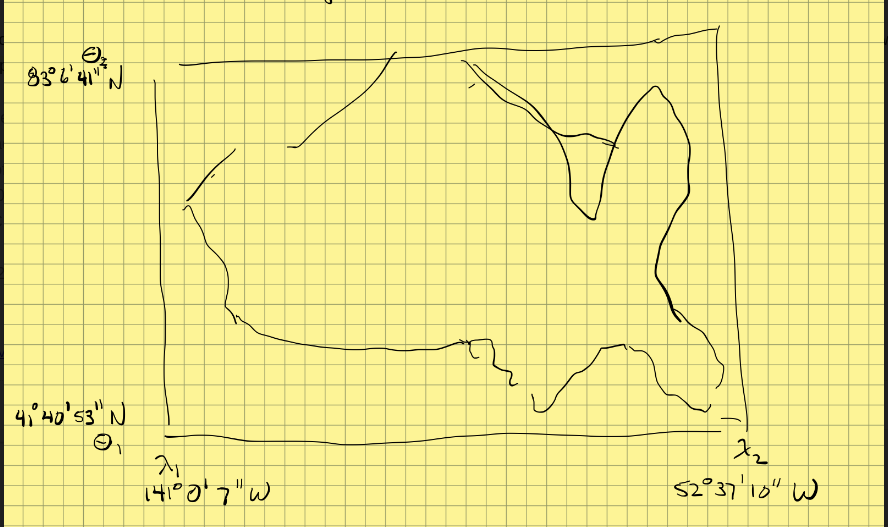

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
Image('/home/nannau/Pictures/canada.png')

### Define the Spatial Basis Functions
Define 3 lat and 6 longitudinal basis functions resembling the approach outlined by the new mapping approach using orthogonal "harmonics".

This time, however, instead of defining Canada into 4 regions as originally proposed, compress it into 12 regions - 3 latitude and 4 longitudinal to define the regions for the harmonic trig functions to span.

i.e. instead of using $\lambda_1$ and $\lambda_2$ to define the absolute boundary, define the midpoint
$$\lambda_s= \frac{\lambda_1 + \lambda_2}{2}$$ 
to become the new $\lambda_2$ on the western boxes, and apply the same functions in the 4 spaces (and 3 central spaces) as before.

In the eastern boxes, simply make $\lambda_1 = \lambda_s$ and apply the same functions. This will give you 18 spatial basis functions. Add together each central spatial basis patterns that have $\lambda_s$ on their boundary to their respective adjacent latitudinal counterpart to get a smooth pattern, and give us the desired 15 patterns. 

In [8]:
def loncos(l, l1, l2):
    return np.cos(2*np.pi*(l1-l)/(l1-l2))
    
def latcos(t, t1, t2):
    return np.cos(2*np.pi*(t-t1)/(t2-t1))
    
def f1(x):
    if (ls <= x and x<= (ls+l1)/2) or (x <= ls):
        return 0.
    elif ((l1+ls)/2. < x) & (x <= l1):
        return (loncos(x, l1, ls)+1)/2.
    else:
        print(ls, l2, x)
        raise ValueError("Did not meet stop criterion.")

def f2(x):

    if (ls<= x) & (x<=l1):
        return (1-loncos(x, l1, ls))/2.
    elif (x <= ls):
        return 0.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")        

def f3(x):
    if (ls <= x) & (x <= (l1+ls)/2):
        return (loncos(x, l1, ls)+1)/2.
    elif ((ls+l1)/2 < x and x <= l1) or (x <= ls):
        return 0.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")

def f4(x):
    if (l2 <= x) & (x <= (l2+ls)/2):
        return (loncos(x, ls, l2)+1)/2.
    elif ((l2+ls)/2 < x and (x <= ls)) or (x >= ls):
        return 0.
    else:
        print(l1, ls, x)
        raise ValueError("Did not meet stop criterion.")

def f5(x):
    if (l2 <= x) & (x<=ls):
        return (1-loncos(x, ls, l2))/2.
    elif (x >= ls):
        return 0.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")   

def f6(x):
    if (x <= ls) & (x >= (l2+ls)/2):
        return (loncos(x, ls, l2)+1)/2.
    elif (x < (l2+ls)/2 and x >= l2) or (x >= ls):
        return 0.
    else:
        print(l1, ls, x)
        raise ValueError("Did not meet stop criterion.")

        
def g1(x):
    if (t1 <= x) & (x <= (t1+t2)/2.):
        return (latcos(x, t1, t2)+1)/2.
    elif ((t1+t2)/2. < x) & (x <= t2):
        return 0.
    else:
        print(t1, t2, x)
        raise NameError("Did not meet stop criterion.")
        
def g2(x): 
    if (t1 <=  x) & (x <= t2):
        return (1-latcos(x, t1, t2))/2.
    else:
        print(t1, t2, x)
        raise ValueError("Did not meet stop criterion.")

def g3(x):
    if (t1 <= x) & (x <= (t1+t2)/2):
        return 0.
    elif (((t1+t2)/2) < x) & (x <= t2):
        return (latcos(x, t1, t2)+1)/2 
    else:
        print(t1, t2, x)
        raise ValueError("Did not meet stop criterion.")
    
def g(m, t):
    if m == 1:
        return g1(t)
    if m == 2:
        return g2(t)
    if m == 3:
        return g3(t)

def f(n, l):
        if n == 1:
            return f1(l)
        if n == 2:
            return f2(l)
        if n == 3:
            return f3(l)
        if n == 4:
            return f4(l)
        if n == 5:
            return f5(l)
        if n == 6:
            return f6(l)

hmn = np.ones((3, 6))
def h(t, l):
    for n in np.arange(1, 7):
        for m in np.arange(1, 4):
            hmn[m-1, n-1] = g(m, t)*f(n, l)
    return hmn

In [9]:
# Convert to regular radian coordinates
lon, lat = np.deg2rad(-(ds.lon.values-360)), np.deg2rad(ds.lat.values)

# Populate the entries of the 3x3 matrix for h_mn 
d = np.ones((ens_mean.flatten().shape[0], hmn.shape[0], hmn.shape[1]))
d_raw = np.ones((ens_mean.flatten().shape[0], hmn.shape[0], hmn.shape[1]))

# Populate cell in ensemble field for each basis function and assign value
# in array full of ones
for i, cell in enumerate(ens_mean.flatten()):
    if final_mask.flatten()[i]:
        cell = np.broadcast_to(cell, (hmn.shape))
        d[i] = np.multiply(cell, h(lat.flatten()[i], lon.flatten()[i]))
        d_raw[i] = h(lat.flatten()[i], lon.flatten()[i])
    else:
        d[i] = np.full(hmn.shape, np.nan)
        d_raw[i] = np.full(hmn.shape, np.nan)

# reshape to logical grid shape
d_grid = d.reshape((ens_mean.shape[0], ens_mean.shape[1], hmn.shape[0], hmn.shape[1]))
d_raw_grid = d_raw.reshape((ens_mean.shape[0], ens_mean.shape[1], hmn.shape[0], hmn.shape[1]))

# add together central components of raw functions
d_raw_grid[:, :, :, 2] = d_raw_grid[:, :, :, 5]+d_raw_grid[:, :, :, 2]
d_raw_grid = d_raw_grid[:, :, :, :-1].reshape(ens_mean.shape[0], ens_mean.shape[1], hmn.shape[0]*(hmn.shape[1]-1))

# add together central components of new anomally weighted centers
d_grid[:, :, :, 2] = d_grid[:, :, :, 5]+d_grid[:, :, :, 2]

# reshape into lower dimension shape
d_grid = d_grid[:, :, :, :-1].reshape(ens_mean.shape[0], ens_mean.shape[1], hmn.shape[0]*(hmn.shape[1]-1))

### Plot the raw basis patterns
Plot the 15 new basis patterns that are now regressed

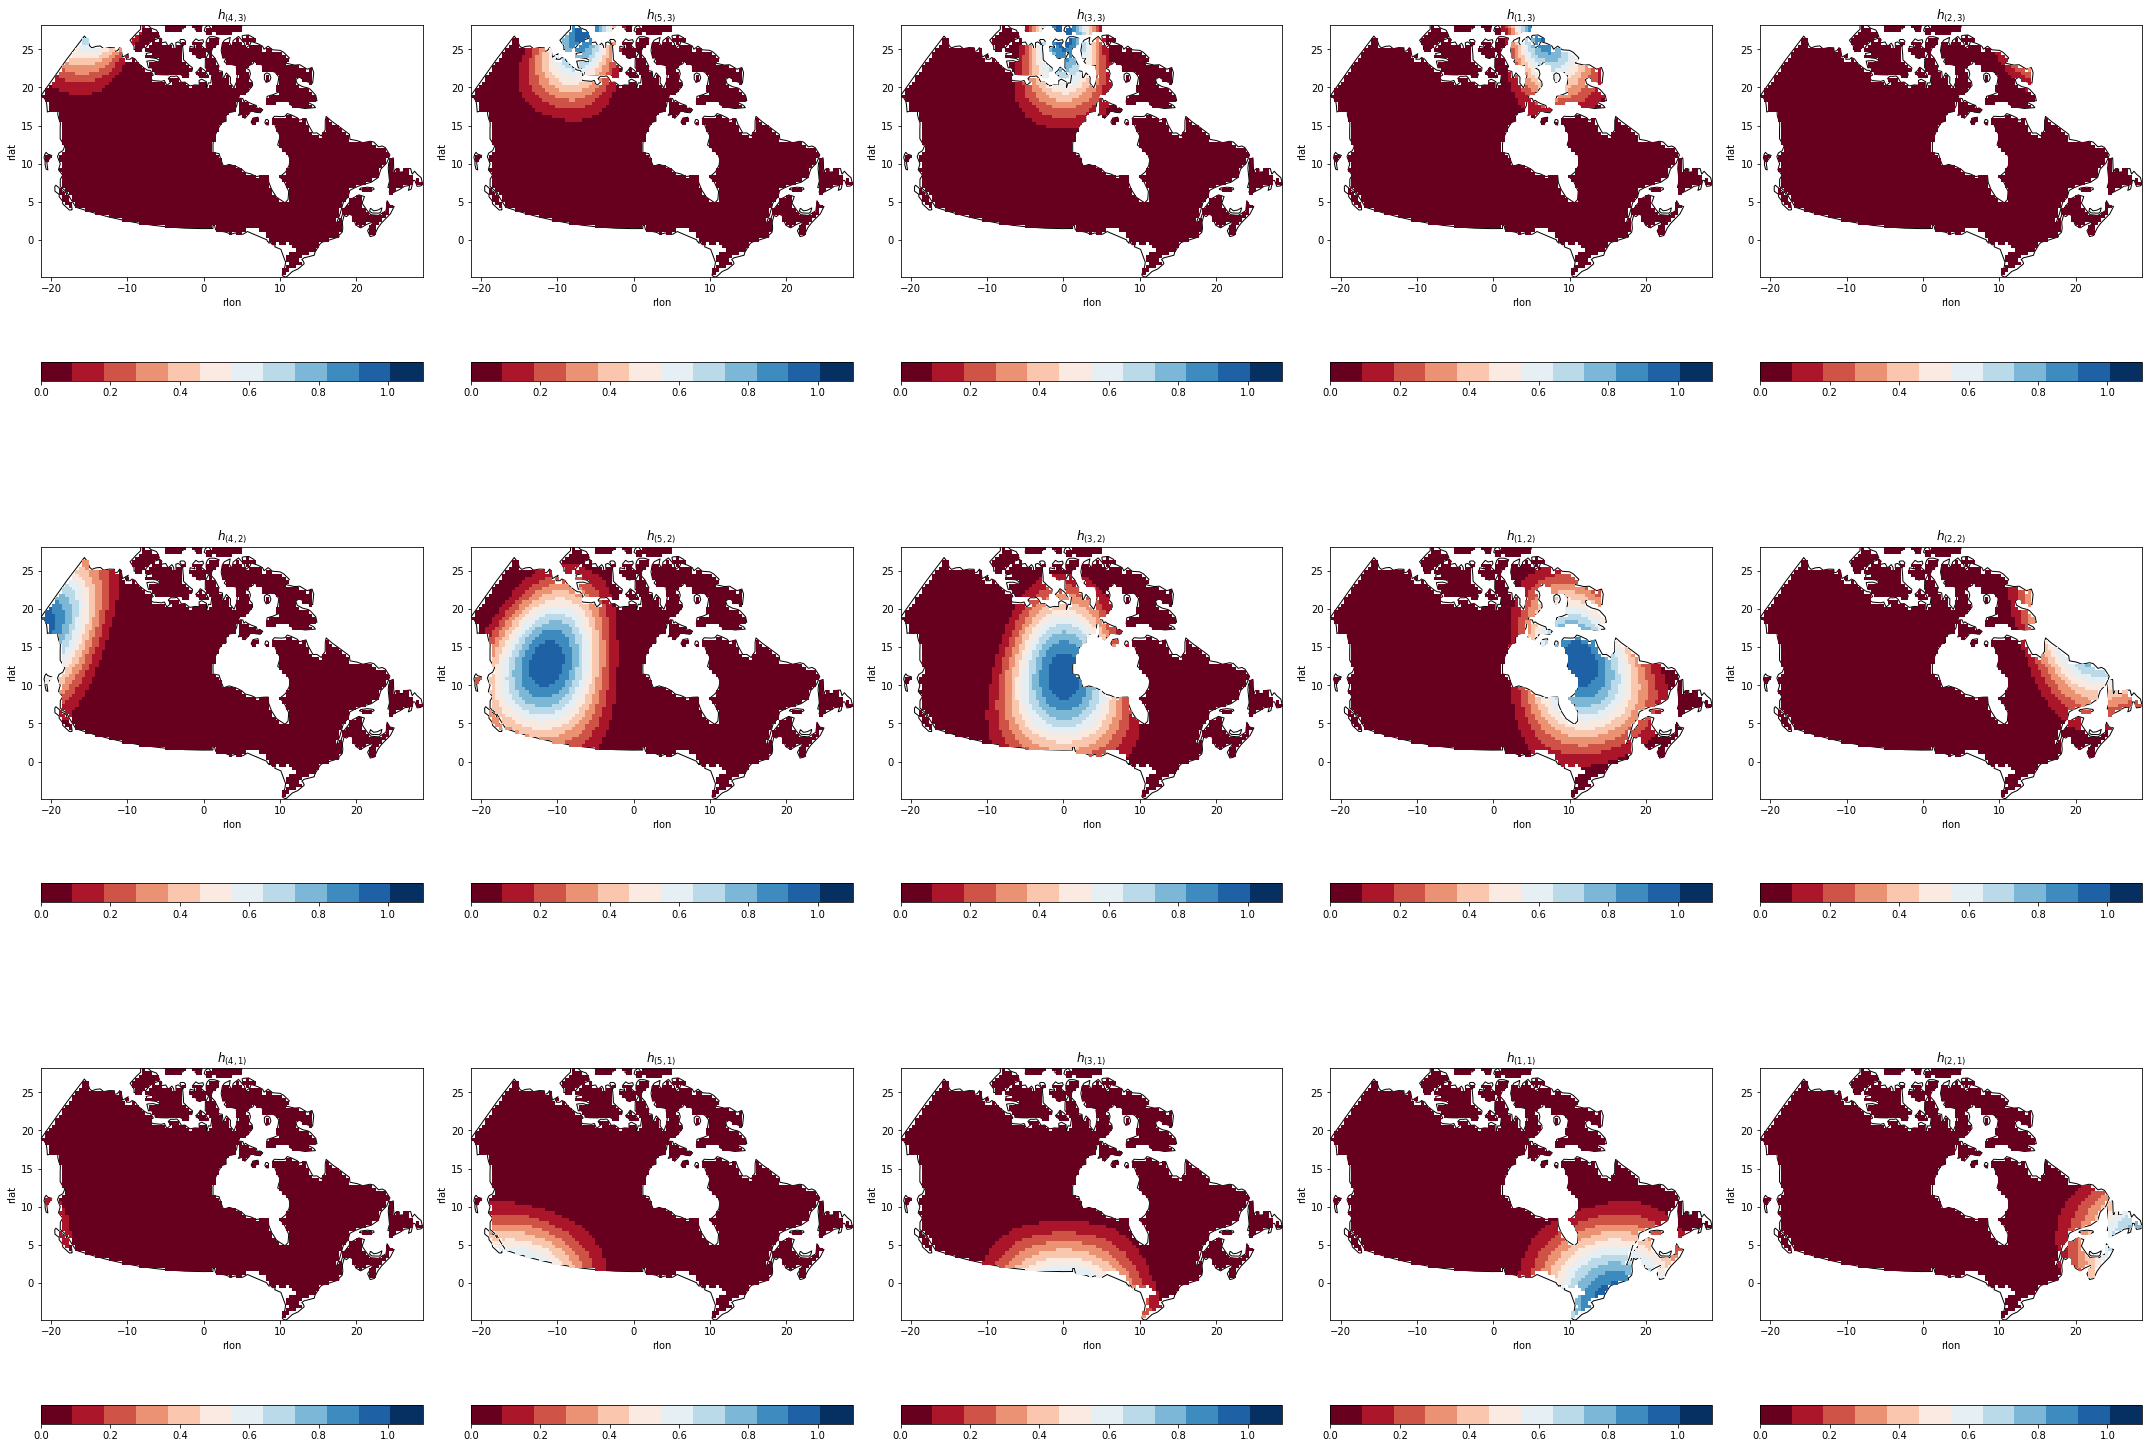

In [11]:
fig, ax = plt.subplots(3, 5, figsize=(30,30))

tuples = [(4,1),(5,1),(3,1),(2,1),(1,1), (4,2),(5,2),(3,2),(2,2),(1,2), (4,3),(5,3),(3,3),(2,3),(1,3)]

tu = [tuple(x) for x in (np.array(tuples) - 1)]
tu.reverse()
tu = [(x[1], x[0]) for x in tu]

x1, x2, y1, y2 = rlon.min(), rlon.max(), rlat.min(), rlat.max()
vmin, vmax = 0., 1.1

for i, t in enumerate(tu):
    ax[t].set_title('$h_{%s}$' % (tuples[i],))
    ax[t].set_xlabel('rlon')
    ax[t].set_ylabel('rlat')
    ax[t].set_ylim(canada.bounds.miny.values[0], y2)
    ax[t].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
    canada.plot(ax=ax[t], color='white', edgecolor='black', zorder=1)

    X = d_raw_grid[:, :, i]

    img = ax[t].imshow(X, origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='spatial basis pattern',vmin=vmin, vmax=vmax, zorder=2,extent=[x1, x2, y1, y2])
    plt.colorbar(img, orientation='horizontal', ax=ax[t],fraction=0.046, pad=0.03)
    plt.tight_layout(rect=[0, 0.2, 1, 2])

### Load the station data from file
Add new columns of converted longitude and latitude into rotated pole coordinate

In [12]:
df = pd.read_csv('../../climpyrical/tests/data/stations.csv', index_col=None)
df['rlon'], df['rlat'] = transform_coords(df['lon'].values, df['lat'].values)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa),RL50 (kPa),rlon,rlat
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,2.0,0.763,-17.245771,4.407283
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.7,0.571,-17.148280,4.041212
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.4,0.795,-17.269400,4.110152
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.8,0.371,-17.157965,3.823732
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.4,0.565,-18.602266,6.674747


### Find nearest grid indices in model to each station location
Note that these warnings indicate that there are stations outside of the CanRCM4 model grid space (these are all far north stations as indicated in the warning statement

In [13]:
rlon_i, rlat_i = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:298: UserWarning: 36.222662646628834 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.
  .format(val, data.min(), data.max())
/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:298: UserWarning: 32.64541886648805 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.
  .format(val, data.min(), data.max())
/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:298: UserWarning: 31.345755932126362 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.
  .format(val, data.min(), data.max())
/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:298: UserW

### Add nearest grid cell information to station dataframe
* Add nearest rlon and rlat locations in grid to stations
* Zip together a tuple of grid indices 
* Create separate index columns for rlon and rlat 
* Group together stations falling in same grid cell and take mean

In [14]:
# Add nearest rlon and rlat locations in grid to stations
df['rlon_nearest'], df['rlat_nearest'] = ds.rlon.values[rlon_i], ds.rlat.values[rlat_i]
df['rlon_nearest_index'], df['rlat_nearest_index'] = rlon_i, rlat_i

# Zip together a tuple of grid indices
df['nearest_grid'] = list(zip(rlon_i, rlat_i))

# Group together stations falling in same grid cell and take mean
station_dv = 'RL50 (kPa)'
ndf = df.groupby(['nearest_grid'], as_index=False).agg({
                                    station_dv: 'mean',
                                    'lat':'min',
                                    'lon':'min',
                                    'rlat':'min',
                                    'rlon':'min',
                                    'rlat_nearest':'min',
                                    'rlon_nearest':'min',
                                    'rlon_nearest_index':'mean',
                                    'rlat_nearest_index':'mean',
                                })
# Remove stations with zero rainfall as advised
df0 = ndf
ndf = ndf[ndf['RL50 (kPa)'] != 0.0]

# Get the indices for each grid axis that are matched and grouped
rlon_i_agg, rlat_i_agg = ndf.rlon_nearest_index.values, ndf.rlat_nearest_index.values

### Plot station locations against their nearest grid locations.
This should be 1:1

Text(0, 0.5, 'Stations Locations')

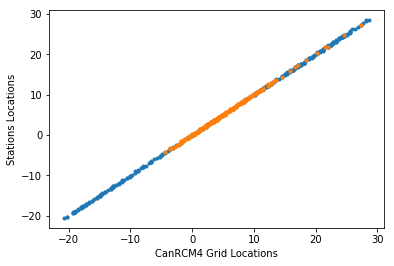

In [15]:
# ensure that the station locations are not far from their corresponding grid locations
plt.scatter(ds.rlon.values[rlon_i_agg], ndf.rlon, marker='.'),
plt.scatter(ds.rlat.values[rlat_i_agg], ndf.rlat, marker='.')
plt.xlabel("CanRCM4 Grid Locations")
plt.ylabel("Stations Locations")

### Plot the spatial distribution of the stations 

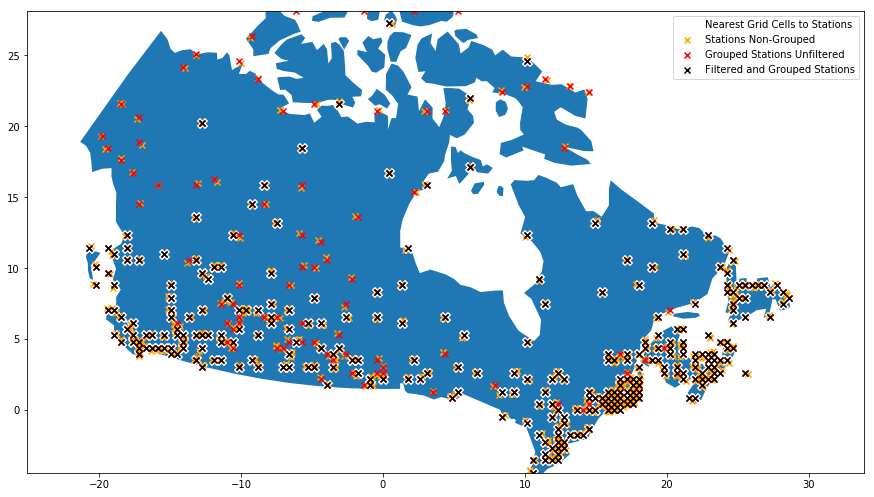

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
# this plots canada
canada.plot(ax=ax)
# this plots the nearest grids to the stations
ax.scatter(ds.rlon.values[rlon_i_agg], ds.rlat.values[rlat_i_agg], color='white', marker='X', s=100, label='Nearest Grid Cells to Stations')
# this plots the stations
ax.scatter(df.rlon.values, df.rlat.values, color='orange', marker='x', label='Stations Non-Grouped')
ax.scatter(df0.rlon_nearest.values, df0.rlat_nearest.values, color='red', marker='x', label='Grouped Stations Unfiltered')
ax.scatter(ndf.rlon_nearest.values, ndf.rlat_nearest.values, color='black', marker='x', label='Filtered and Grouped Stations')
ax.set_ylim(ds.rlat[rlat_i].values.min(), ds.rlat[rlat_i].values.max())
ax.set_xlim(ds.rlon[20:].values.min(), ds.rlon[-10:].values.max())
plt.legend()

### Find the nearest grid cell value to each station

In [17]:
bases = [find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, d_grid[:, :, i], final_mask, ds) for i in range(15)]
values = np.stack(bases)

In [18]:
# Check that the final predictor and predictants are the same shape
values.shape, ndf['RL50 (kPa)'].values.shape

((15, 292), (292,))

### Perform regression and plot the regression results

slope of plot 0.7857538034944449 r2_val of plot 0.8864275511819589


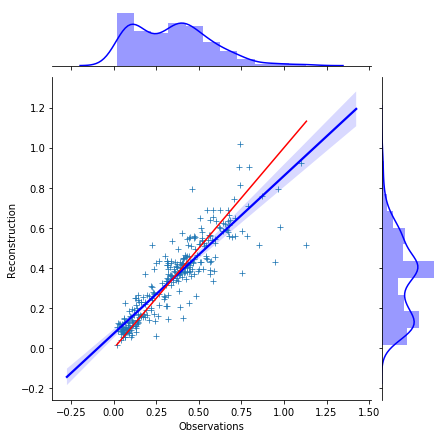

In [19]:
from sklearn import ensemble
from sklearn import linear_model
import seaborn as sns
from scipy.stats import linregress

X, Y = values.T, ndf['RL50 (kPa)'].values

# Fit regression model
# params = {'n_estimators': 350, 'max_depth': 4, 'min_samples_split': 2,
#           'learning_rate': 0.007, 'loss': 'ls'}
# model = ensemble.GradientBoostingRegressor(**params)
model = linear_model.LinearRegression()
model.fit(X, Y)

sns.jointplot(Y, model.predict(X), kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(Y, model.predict(X), marker='+')
sns.lineplot(Y, Y, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(Y, model.predict(X))
print("slope of plot", slope, "r2_val of plot", r_value)

### Regression Score

In [20]:
model.score(X, Y)

0.7857538034944451

### Reconstruct the entire field

In [23]:
dc = d_grid[..., 0].flatten().copy()
dc[final_mask.flatten()] = model.predict(d_grid[final_mask])

In [24]:
final = dc.reshape(d_grid[..., 0].shape)

### Plot the final reconstructed field

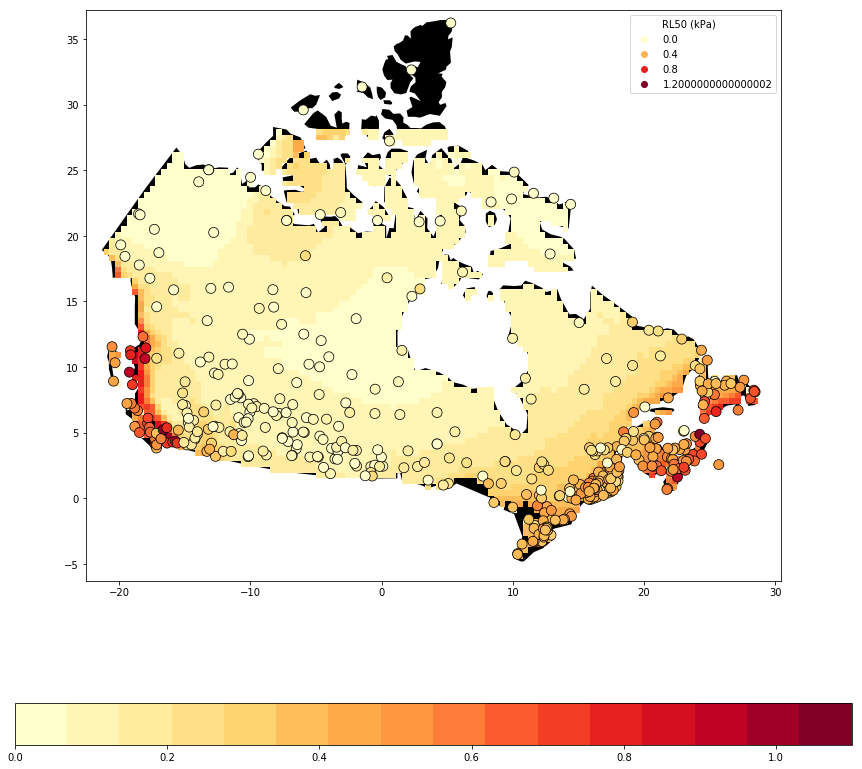

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
canada.plot(ax=ax, color='black', zorder=0)
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax, palette='YlOrRd', s=100, edgecolor='black', hue_norm=(vmin, vmax))
img = ax.imshow(final, origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()], cmap=plt.get_cmap('YlOrRd', 16), vmin=vmin, vmax=vmax)
plt.colorbar(img, orientation='horizontal')
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions')

### Change the colors to highlight contours

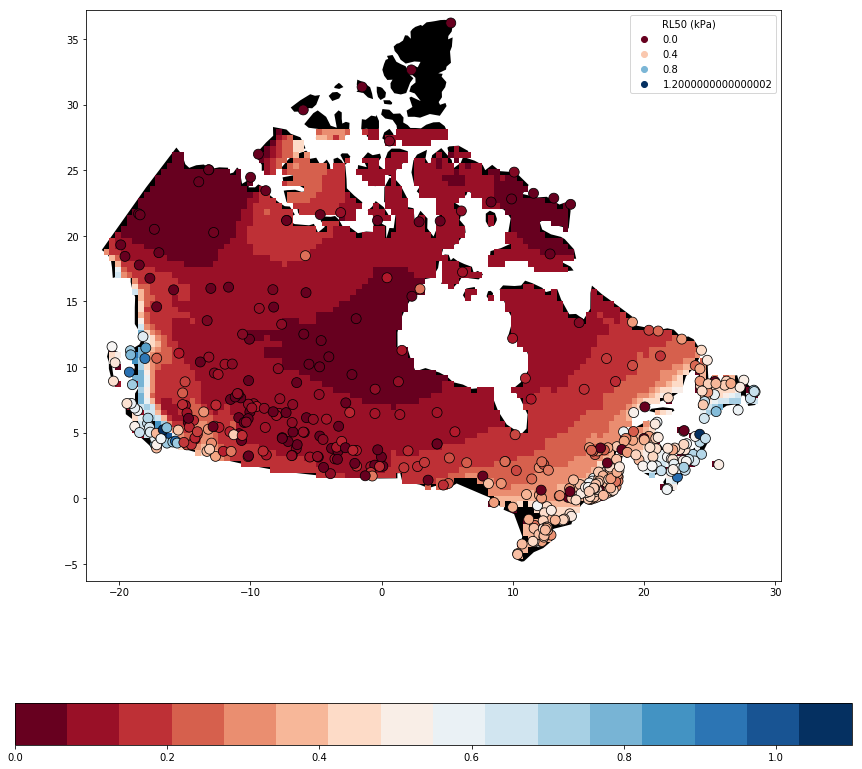

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))
canada.plot(ax=ax, color='black', zorder=0)
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax, palette='RdBu', s=100, edgecolor='black', hue_norm=(vmin, vmax))
img = ax.imshow(
        final,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('RdBu', 16), vmin=vmin, vmax=vmax
)

plt.colorbar(img, orientation='horizontal')
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions')

### Plot the ensemble mean

(-22.54536787529786, 30.474338160291843)

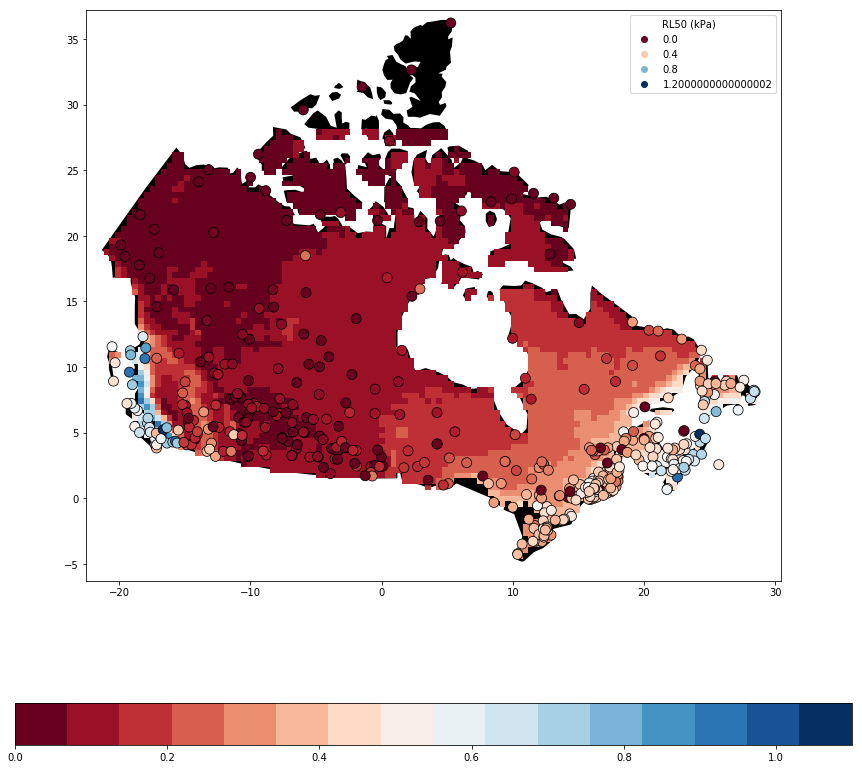

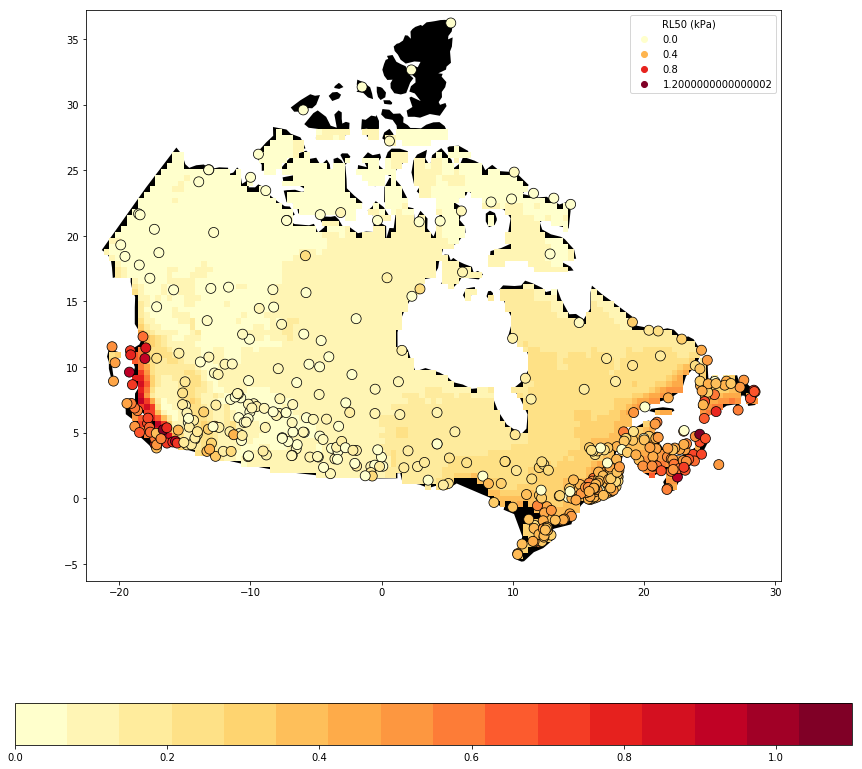

In [27]:
ens_mean_with_nan = ens_mean.copy()
ens_mean_with_nan[~final_mask] = np.nan
ens_mean_with_nan = ens_mean_with_nan.reshape(ens_mean.shape)

fig, ax = plt.subplots(figsize=(15, 15))
canada.plot(ax=ax, color='black', zorder=0)
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax, palette='RdBu', s=100, edgecolor='black', hue_norm=(vmin, vmax))
img = ax.imshow(
        ens_mean_with_nan,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('RdBu', 16), vmin=vmin, vmax=vmax
)

# On a new color scheme
plt.colorbar(img, orientation='horizontal')
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)

fig, ax = plt.subplots(figsize=(15, 15))
canada.plot(ax=ax, color='black', zorder=0)
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax, palette='YlOrRd', s=100, edgecolor='black', hue_norm=(vmin, vmax))
img = ax.imshow(
        ens_mean_with_nan,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('YlOrRd', 16), vmin=vmin, vmax=vmax
)

plt.colorbar(img, orientation='horizontal')
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)

### Upscale/Interpolate the final reconstructed field 10 fold

In [29]:
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator

rlon_ens, rlat_ens = flatten_coords(ds.rlon.values, ds.rlat.values, ds)
irlat, irlon = np.linspace(rlat.min(), rlat.max(), rlat.shape[0]*10), np.linspace(rlon.min(), rlon.max(), rlon.shape[1]*10)

x, y = flatten_coords(irlon, irlat, ds)
points = np.array(list(zip(x, y)))
np.array(list(zip(rlon_ens, rlat_ens))), d_grid[final_mask], final[final_mask].flatten()

iff = LinearNDInterpolator(list(zip(rlon_ens, rlat_ens)), final.flatten())
ifinal = iff(points)

In [30]:
# reshape into a grid
ifinal = ifinal.reshape(irlat.shape[0], irlon.shape[0])

### Plot final interpolated field

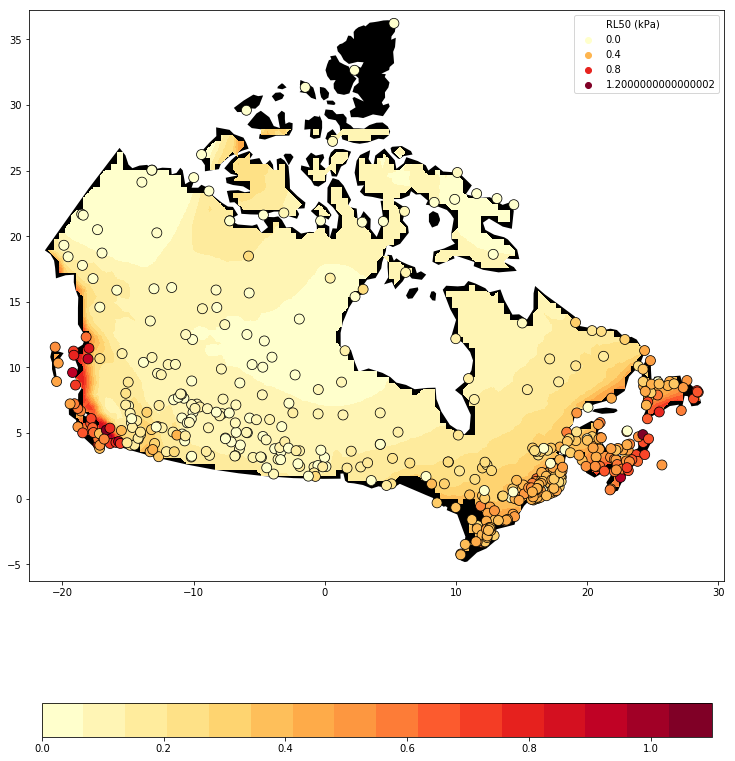

In [31]:
fig, ax = plt.subplots(figsize=(15, 15))

# this plots canada
canada.plot(ax=ax, color='black', zorder=0)
vmin, vmax = 0., .5
vmin, vmax = 0., 1.1
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax, palette='YlOrRd', s=100, edgecolor='black', hue_norm=(vmin, vmax))
img = ax.imshow(ifinal, origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()], cmap=plt.get_cmap('YlOrRd', 16), vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax, orientation='horizontal',shrink=0.8)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions')